<a href="https://colab.research.google.com/github/ontoligent-design/DS5559/blob/master/first_foray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assumptions

* Do not preserve punction and whitespace 
* Work with a single text

# Settings

In [81]:
WIDE = (15,3)
THIN = (5,15)

# Imports

In [3]:
import sqlite3
import pandas as pd
import re
import requests
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [4]:
%matplotlib inline

# F0: Acquire the source

We work the plaintext version of Moby Dick. Note that a good XML version is available from the OTA at http://ota.ox.ac.uk/desc/3049. However, the text version there is flawed. For that, we use the Project Gutenberg version at https://www.gutenberg.org/files/2701/old/moby10b.txt. The following assumes that we have downloaded the file and named it `moby.txt`.


In [5]:
moby_text = open('moby.txt','r').readlines()

In [6]:
# See what's inside
moby_text[:10]

['**The Project Gutenberg Etext of Moby Dick, by Herman Melville**\n',
 '#3 in our series by Herman Melville\n',
 '\n',
 'This Project Gutenberg version of Moby Dick is based on a combination\n',
 'of the etext from the ERIS project at Virginia Tech and another from\n',
 "Project Gutenberg's archives, as compared to a public-domain hard copy.\n",
 '\n',
 'Copyright laws are changing all over the world, be sure to check\n',
 'the copyright laws for your country before posting these files!!\n',
 '\n']

In [7]:
# We import the list of lines into a Pandas data frame.
moby_lines = pd.DataFrame(moby_text, columns=['line'])
moby_lines.index.name = 'line_id'
moby_lines['line'] = moby_lines['line'].str.strip()

After manually inspecting the file, we determine the start and end line numbers of the text itself. To generalize this, we'd figure out if the front and backmatter added by Project Gutenberg is predictable, either by number of lines of a pattern in the text. Note that the ability to predict these features depends heavily on the corpus.

In [8]:
moby_start = 318
moby_end = 23238
moby_lines = moby_lines.loc[moby_start:moby_end].copy()
moby_lines.reset_index(drop=True, inplace=True)
moby_lines.index.name = 'line_id'

In [9]:
moby_lines.head()

,line
line_id,
0,ETYMOLOGY.
1,
2,(Supplied by a Late Consumptive Usher to a Gra...
3,
4,"The pale Usher--threadbare in coat, heart, bod..."


In [10]:
moby_lines.tail()

,line
line_id,
22916,"sheathed beaks. On the second day, a sail dre..."
22917,picked me up at last. It was the devious-crui...
22918,her retracing search after her missing childre...
22919,orphan.
22920,


# F1: Structure by Chapters and Paragraphs

## Chapters

We apply the **milestone method** to identify, label, and group lines. Manual inspection shows that the chapters all begin with CHAPTER, and that there is an Epilogue at the end and a section called EYTMOLOGY at the beginning. Actually, there are a couple of sections before CHAPTER 1, but we'll preserve them as a single chapter. Note: some just remove this section, but we do not because it's actually part of the text.

In [11]:
moby_lines['chap_ms'] = moby_lines.line\
  .str.match(r'^(?:ETYMOLOGY|CHAPTER \d+|Epilog)')

In [12]:
moby_lines.head()

,line,chap_ms
line_id,,
0,ETYMOLOGY.,True
1,,False
2,(Supplied by a Late Consumptive Usher to a Gra...,False
3,,False
4,"The pale Usher--threadbare in coat, heart, bod...",False


In [13]:
moby_lines['chap_idx'] = None # Not sure why this has to be initialized
moby_lines['chap_idx'] = moby_lines[moby_lines.chap_ms]\
  .apply(lambda x: x.index)
moby_lines.chap_idx = moby_lines.chap_idx.ffill()
moby_lines.chap_idx = moby_lines['chap_idx'].astype('int')

In [14]:
moby_lines.head()

,line,chap_ms,chap_idx
line_id,,,
0,ETYMOLOGY.,True,0
1,,False,0
2,(Supplied by a Late Consumptive Usher to a Gra...,False,0
3,,False,0
4,"The pale Usher--threadbare in coat, heart, bod...",False,0


In [15]:
moby_chaps = moby_lines.groupby('chap_idx').line\
  .apply(lambda x: '\n'.join(x[:])).to_frame().reset_index(drop=True)
moby_chaps.index.name = 'chap_id'

In [16]:
moby_chaps.head()

,line
chap_id,
0,ETYMOLOGY.\n\n(Supplied by a Late Consumptive ...
1,CHAPTER 1\n\nLoomings.\n\n\nCall me Ishmael. ...
2,CHAPTER 2\n\nThe Carpet-Bag.\n\n\nI stuffed a ...
3,CHAPTER 3\n\nThe Spouter-Inn.\n\n\nEntering th...
4,CHAPTER 4\n\nThe Counterpane.\n\n\nUpon waking...


In [17]:
# Optionally remove chapter names here (split and pop off first chunk)

## Paragraphs

In [18]:
moby_paras = moby_chaps.line.str.split(r'\n\n+', expand=True).stack()\
  .to_frame().reset_index().rename(columns={'level_1':'para_id', 0:'para'})
moby_paras.set_index(['chap_id','para_id'], inplace=True)
moby_paras.para = moby_paras.para.str.replace(r'\n', ' ')

In [19]:
moby_paras.head()

para
chap_id para_id                                                   
0       0                                               ETYMOLOGY.
        1        (Supplied by a Late Consumptive Usher to a Gra...
        2        The pale Usher--threadbare in coat, heart, bod...
        3        "While you take in hand to school others, and ...
        4        "WHALE. ... Sw. and Dan. HVAL.  This animal is...

In [20]:
moby_paras.loc[(2,3)].para

'As most young candidates for the pains and penalties of whaling stop at this same New Bedford, thence to embark on their voyage, it may as well be related that I, for one, had no idea of so doing.  For my mind was made up to sail in no other than a Nantucket craft, because there was a fine, boisterous something about everything connected with that famous old island, which amazingly pleased me.  Besides though New Bedford has of late been gradually monopolising the business of whaling, and though in this matter poor old Nantucket is now much behind her, yet Nantucket was her great original--the Tyre of this Carthage;--the place where the first dead American whale was stranded.  Where else but from Nantucket did those aboriginal whalemen, the Red-Men, first sally out in canoes to give chase to the Leviathan?  And where but from Nantucket, too, did that first adventurous little sloop put forth, partly laden with imported cobblestones--so goes the story--to throw at the whales, in order t

# F2: Parse Sentences and Tokens

We identify tokens by delimitter parsing. Delimitters are represented by character classes.

## Sentences

Sentence are actually a container.

In [21]:
moby_sent = moby_paras.para.str.split(r'(?:[":;.?!\(\)]|--)', expand=True)\
  .stack()\
  .to_frame().reset_index().rename(columns={'level_2':'sent_id', 0:'sent'})
moby_sent.set_index(['chap_id', 'para_id', 'sent_id'], inplace=True)
moby_sent = moby_sent[~moby_sent.sent.str.match(r'^\s*$')]

In [22]:
moby_sent

sent
chap_id para_id sent_id                                                   
0       0       0                                                ETYMOLOGY
        1       1        Supplied by a Late Consumptive Usher to a Gram...
        2       0                                           The pale Usher
                1               threadbare in coat, heart, body, and brain
                2                                            I see him now
                3          He was ever dusting his old lexicons and gra...
                4                        He loved to dust his old grammars
                5          it somehow mildly reminded him of his mortality
        3       1        While you take in hand to school others, and t...
                4                                                 HACKLUYT
        4       1                                                    WHALE
                5                                                       Sw
                6                                                  and Dan
                7                                                     HVAL
                8           This animal is named from roundness or rolling
                9                                               for in Dan
                10                              HVALT is arched or vaulted
                13                                    WEBSTER'S DICTIONARY
        5       1                                                    WHALE
                5                      It is more immediately from the Dut
                6                                                  and Ger
                7                                                   WALLEN
                8                                                        A
                9                                                        S
                10                            WALW-IAN, to roll, to wallow
                13                                 RICHARDSON'S DICTIONARY
        6       0                               KETOS,               GREEK
                1                               CETUS,               LATIN
                2                         WHOEL,               ANGLO-SAXON
                3                              HVALT,               DANISH
...                                                                    ...
135     61      7                    only the uppermost masts out of water
                8         while fixed by infatuation, or fidelity, or f...
                9          And now, concentric circles seized the lone ...
        62      0        But as the last whelmings intermixingly poured...
                2        at that instant, a red arm and a hammer hovere...
                3          A sky-hawk that tauntingly had followed the ...
                4         this bird now chanced to intercept its broad ...
                5         and simultaneously feeling that etherial thri...
                6         and so the bird of heaven, with archangelic s...
        63      0        Now small fowls flew screaming over the yet ya...
                1         a sullen white surf beat against its steep sides
                2         then all collapsed, and the great shroud of t...
136     0       0                                                 Epilogue
        1       1                 AND I ONLY AM ESCAPED ALONE TO TELL THEE
                2                                                      Job
        2       0                                         The drama's done
                1                    Why then here does any one step forth
                3                        Because one did survive the wreck
        3       0        It so chanced, that after the Parsee's disappe...
                1         the same, who, when on the last day the three...
                2          So, floating on the margin of the ensuing sc...
                3   

In [23]:
# Re-order the sentence IDs -- NEED TO GENERALIZE THIS PATTERN
moby_sent['new_sent_idx'] = moby_sent.groupby(['chap_id','para_id']).cumcount()
moby_sent = moby_sent.reset_index()
moby_sent.rename(columns={'sent_id':'delete_me'}, inplace=True)
moby_sent.rename(columns={'new_sent_idx':'sent_id'}, inplace=True)
moby_sent = moby_sent.set_index(['chap_id','para_id','sent_id'])['sent']\
  .to_frame()

In [24]:
moby_sent.head()

sent
chap_id para_id sent_id                                                   
0       0       0                                                ETYMOLOGY
        1       0        Supplied by a Late Consumptive Usher to a Gram...
        2       0                                           The pale Usher
                1               threadbare in coat, heart, body, and brain
                2                                            I see him now

## Tokens

In [25]:
moby_tokens = moby_sent.sent.str.split(r'\W+', expand=True).stack()\
  .to_frame().reset_index().rename(columns={'level_3':'token_id', 0:'token'})
moby_tokens.set_index(['chap_id', 'para_id', 'sent_id', 'token_id'], 
                      inplace=True)

In [26]:
moby_tokens.head()

token
chap_id para_id sent_id token_id           
0       0       0       0         ETYMOLOGY
        1       0       0          Supplied
                        1                by
                        2                 a
                        3              Late

In [27]:
moby_tokens['norm'] = moby_tokens.token.str.lower()

In [28]:
moby_tokens.head()

token       norm
chap_id para_id sent_id token_id                      
0       0       0       0         ETYMOLOGY  etymology
        1       0       0          Supplied   supplied
                        1                by         by
                        2                 a          a
                        3              Late       late

# F2: Create Vocabulary

In [29]:
moby_vocab = pd.DataFrame(moby_tokens.token.str.lower().sort_values().unique(), columns=['term'])
moby_vocab.index.name = 'term_id'

In [30]:
moby_vocab.sample(10)

,term
term_id,
6259,gait
6391,get
13560,skulls
9442,methodic
14596,sunny
6576,gradations
1104,authoritatively
8400,killers
11737,pulls


## Get Term ID function

In [31]:
def term_id(term):
    try:
        return moby_vocab.query("term == @term").index[0]
    except IndexError as e:
        return None

## Stopwords

We get our stopwords from an external source. We could have used NLTK.

In [32]:
stopwords = requests\
  .get('https://algs4.cs.princeton.edu/35applications/stopwords.txt')\
  .text.split('\n')

In [33]:
stopwords[:10]

["a's",
 'able',
 'about',
 'above',
 'according',
 'accordingly',
 'across',
 'actually',
 'after',
 'afterwards']

In [34]:
moby_vocab['sw'] = moby_vocab.term.apply(lambda x: 
                                         x in stopwords 
                                         or len(x) < 2 
                                         or not x.isalpha())

In [35]:
moby_vocab[moby_vocab.term.str.match(r'\d(?:nd|th|st|rd)')]

,term,sw
term_id,,
85,1st,True
101,2nd,True
128,4th,True
142,5th,True


## Replace terms in  with IDs

In [36]:
moby_tokens['term_id'] = moby_tokens.norm.map(moby_vocab.reset_index()\
  .set_index('term').term_id)\
  .fillna(-1).astype('int')

In [37]:
moby_tokens.head()

token       norm  term_id
chap_id para_id sent_id token_id                               
0       0       0       0         ETYMOLOGY  etymology     5198
        1       0       0          Supplied   supplied    14638
                        1                by         by     2178
                        2                 a          a      190
                        3              Late       late     8580

In [38]:
moby_tokens = moby_tokens[['token','term_id']]

In [39]:
moby_tokens.head()

token  term_id
chap_id para_id sent_id token_id                    
0       0       0       0         ETYMOLOGY     5198
        1       0       0          Supplied    14638
                        1                by     2178
                        2                 a      190
                        3              Late     8580

## Add raw term counts to vocab

In [40]:
moby_vocab['n'] = moby_tokens.groupby('term_id').term_id.count()

In [41]:
n_words = moby_vocab.n.sum()
n_words_adj = moby_vocab[~moby_vocab.sw].n.sum()

In [42]:
n_words, n_words_adj

(231376, 90791)

In [43]:
moby_vocab['freq'] = moby_vocab.n.div(n_words)

In [44]:
moby_vocab.loc[~moby_vocab.sw, 'adj_freq'] = moby_vocab[~moby_vocab.sw].n\
  .div(n_words_adj)

In [45]:
moby_vocab.sample(10)

,term,sw,n,freq,adj_freq
term_id,,,,,
6639,greeks,False,2,0.000009,0.000022
11936,rake,False,2,0.000009,0.000022
15299,tolerable,False,5,0.000022,0.000055
16736,whatever,True,46,0.000199,NaN
6499,glowed,False,1,0.000004,0.000011
5955,foolish,False,17,0.000073,0.000187
558,allegiance,False,1,0.000004,0.000011
4554,doubloons,False,7,0.000030,0.000077
12757,sagittarius,False,2,0.000009,0.000022


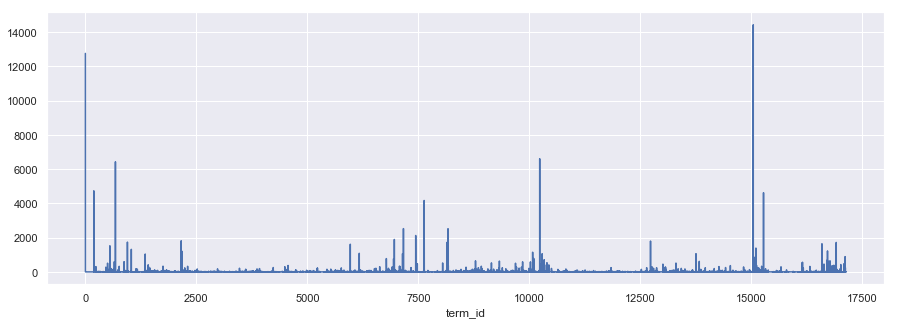

In [46]:
moby_vocab.n.plot(figsize=WIDE)

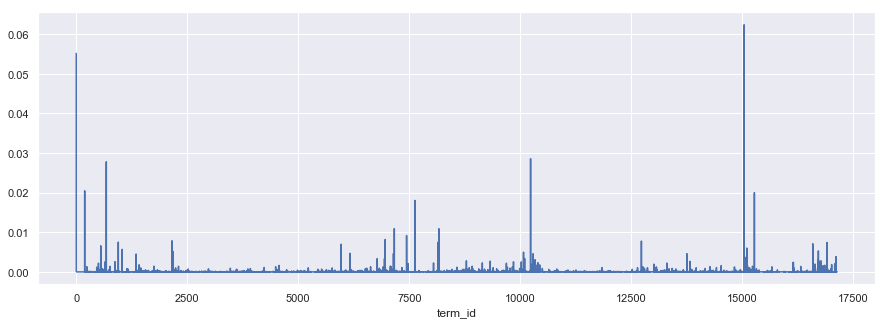

In [47]:
moby_vocab.freq.plot(figsize=WIDE)

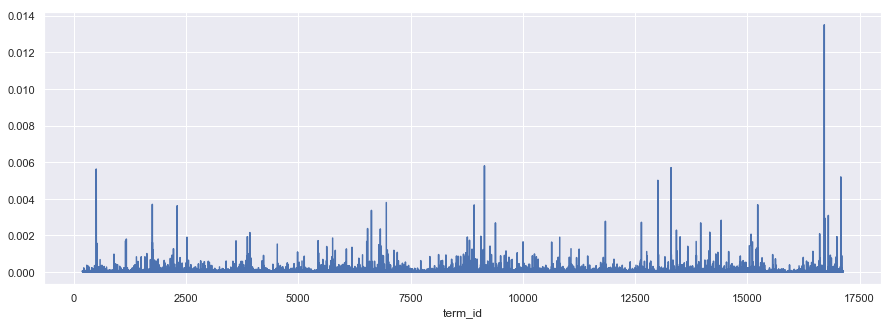

In [48]:
moby_vocab.adj_freq.plot(figsize=WIDE)

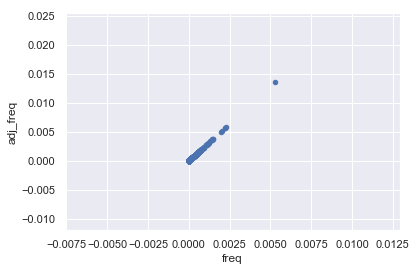

In [49]:
moby_vocab.plot(kind='scatter', x='freq', y='adj_freq')

In [50]:
moby_vocab.loc[moby_vocab.adj_freq.idxmax()].term

'whale'

In [51]:
moby_vocab.describe()

,n,freq,adj_freq
count,17139.000000,17139.000000,16487.000000
mean,13.499971,0.000058,0.000061
std,188.001139,0.000813,0.000214
min,1.000000,0.000004,0.000011
25%,1.000000,0.000004,0.000011
50%,2.000000,0.000009,0.000022
75%,4.000000,0.000017,0.000044
max,14431.000000,0.062370,0.013504


In [52]:
moby_vocab = moby_vocab.query('sw == 0 & n > 2') 

In [53]:
moby_vocab.describe()

,n,freq,adj_freq
count,6318.000000,6318.000000,6318.000000
mean,12.316239,0.000053,0.000136
std,30.192428,0.000130,0.000333
min,3.000000,0.000013,0.000033
25%,3.000000,0.000013,0.000033
50%,6.000000,0.000026,0.000066
75%,11.000000,0.000048,0.000121
max,1226.000000,0.005299,0.013504


## Create lite version of tokens

In [54]:
moby_tokens = moby_tokens[moby_tokens.term_id.isin(moby_vocab.index.values)]

In [55]:
moby_tokens

token  term_id
chap_id para_id sent_id token_id                       
0       1       0       0             Supplied    14638
                        3                 Late     8580
                        9               School    12913
        2       0       1                 pale    10557
                1       2                 coat     2880
                        3                heart     6992
                        4                 body     1763
                        6                brain     1895
                3       12               queer    11841
                        13        handkerchief     6835
                        15         embellished     4916
                        19                 gay     6330
                        25             nations     9906
                        28               world    16995
                4       2                loved     8975
                        4                 dust     4722
                5       3               mildly     9482
                        4             reminded    12231
        3       0       4                 hand     6827
                        6               school    12913
                        10               teach    14935
                        16               whale    16715
                        17                fish     5765
                        21              called     2220
                        24              tongue    15315
                        25             leaving     8665
                        28           ignorance     7487
                        30              letter     8719
                        35              maketh     9123
                        40                word    16982
...                                        ...      ...
136     3       6       28                 sea    13008
                        29                fell     5641
                        32             floated     5868
                        35                side    13422
                7       1               Buoyed     2118
                        5               coffin     2908
                        10                 day     3866
                        12               night    10006
                        14             floated     5868
                        17                soft    13781
                        20                main     9105
                8       3               sharks    13241
                        5               glided     6466
                        13              mouths     9751
                9       2               savage    12849
                        3                  sea    13008
                        4                hawks     6949
                        5               sailed    12761
                10      4                  day     3866
                        6                 sail    12760
                        7                 drew     4626
                        9               nearer     9932
                        11              picked    10978
                11      4              devious     4196
                        5             cruising     3678
                        6               Rachel    11898
                        11              search    13018
                        14             missing     9559
                        15            children     2615
                        17               found     6071

[77814 rows x 2 columns]

## Graph top terms

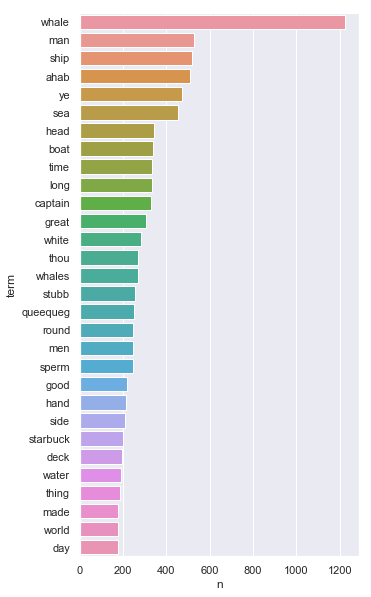

In [56]:
top_terms = moby_vocab.sort_values('n', ascending=False).head(30)
plt.figure(figsize=(5,10))
sns.barplot(data=top_terms, y='term', x='n', orient='h')
plt.show()

# Dispersion Plots

## Convert tokens into OHE matrix

In [57]:
kahuna = pd.get_dummies(moby_tokens.reset_index()['term_id']).T
kahuna['term'] = moby_vocab.term
kahuna = kahuna.reset_index().set_index('term').drop('index', axis=1)

In [58]:
kahuna.head()

,0,1,2,3,4,5,6,7,8,9,...,77804,77805,77806,77807,77808,77809,77810,77811,77812,77813
term,,,,,,,,,,,,,,,,,,,,,
abandon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandoned,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abated,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abhorred,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abide,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
terms = ['stubb', 'ahab','whale', 'starbuck', 'queequeg', 'ishmael', 'white', 'sea', 'ship', 'church', 'death']

In [60]:
viz_df = kahuna.loc[terms].T\
  .stack()\
  .to_frame()\
  .reset_index()\
  .rename(columns={'level_0': 't', 'level_1':'term', 0:'n'})

In [61]:
viz_df[viz_df.n > 0].sample(5)

,t,term,n
263434,23948,white,1
774547,70413,queequeg,1
775838,70530,ship,1
360015,32728,sea,1
751290,68299,ahab,1


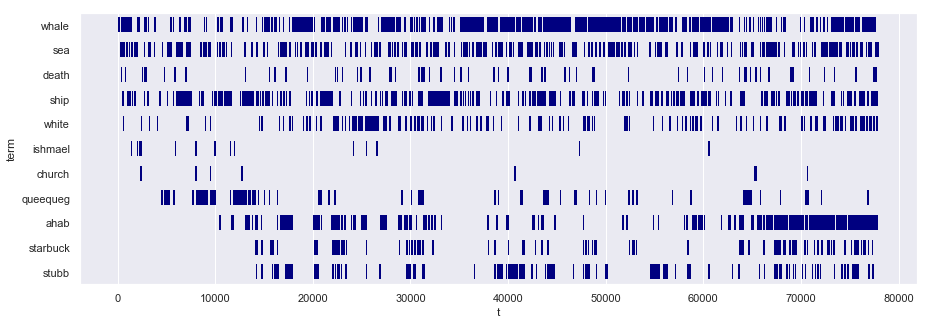

In [91]:
plt.figure(figsize=(15,5))
sns.stripplot(y='term', x='t', data=viz_df[viz_df.n == 1],
 orient='h', marker="$|$", color='navy', size=15, jitter=0)
plt.show()

# F3: Create BOW

## BOW by Chap

In [63]:
moby_bow_chaps = moby_tokens\
  .groupby(['chap_id','term_id'])\
  .term_id.count()\
  .to_frame().rename(columns={'term_id':'n'})

In [64]:
moby_bow_chaps.head()

n
chap_id term_id   
0       259      1
        260      1
        289      2
        319      1
        328      1

# F3: Create DTM

## DTM by Chap

In [65]:
moby_dtm_chaps = moby_bow_chaps.unstack().fillna(0)
moby_dtm_chaps.columns = moby_dtm_chaps.columns.droplevel()

In [66]:
moby_dtm_chaps.head()

term_id,193,194,201,210,214,222,224,228,233,235,...,17104,17107,17108,17110,17113,17122,17127,17132,17134,17136
chap_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# F3: Create TFIDF Matrix

## Get N docs

In [67]:
N = len(moby_dtm_chaps.index)

In [68]:
N

137

## TFIDF by Chap

In [69]:
moby_dtm_tfidf_chaps = moby_dtm_chaps.apply(lambda row: row / row.sum(), 1).apply(lambda col: col * np.log(N/col[col > 0].count()))

In [70]:
moby_bow_chaps['tfidf'] = moby_dtm_tfidf_chaps.stack().to_frame().rename(columns={0:'tfidf'})

In [71]:
moby_dtm_tfidf_chaps.head()

term_id,193,194,201,210,214,222,224,228,233,235,...,17104,17107,17108,17110,17113,17122,17127,17132,17134,17136
chap_id,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.002307,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.005603,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.006906,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.007139,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.002876,0.0,0.000000,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.001208,0.004337,0.000000,0.0,0.0,...,0.0,0.001526,0.000000,0.000000,0.002921,0.0,0.005439,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0


# Term Frequency Graphs

## TFIDF by Chap

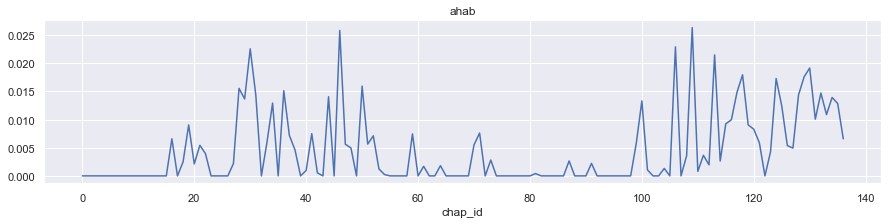

In [89]:
moby_dtm_tfidf_chaps.T.loc[term_id('ahab')].plot(figsize=WIDE, title='ahab')
plt.show()

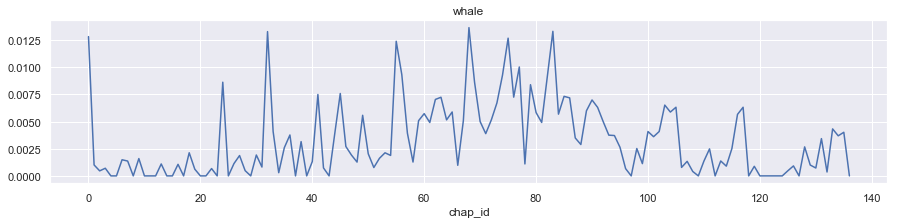

In [88]:
moby_dtm_tfidf_chaps.T.loc[term_id('whale')].plot(figsize=WIDE, title='whale')
plt.show()

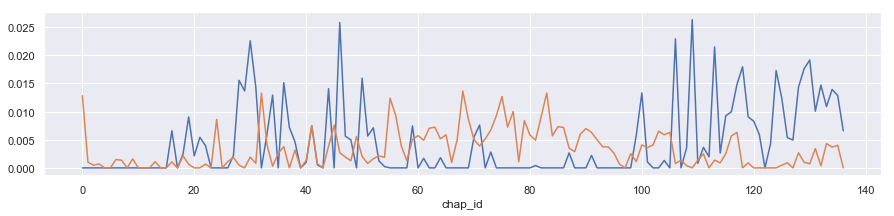

In [90]:
moby_dtm_tfidf_chaps.T.loc[term_id('ahab')].plot(figsize=WIDE)
moby_dtm_tfidf_chaps.T.loc[term_id('whale')].plot(figsize=WIDE)

# Term Correlations

In [74]:
corr_terms = [term_id(term) for term in terms]
corr_cols = {term_id(term):term for term in terms}

In [75]:
def corr_plot_terms(terms, dtm, title='Foo'):
    plt.figure(figsize = (10,10))
    print(title)
    corr = dtm[corr_terms].rename(columns=corr_cols).corr()
    sns.heatmap(corr, vmax=.3, annot=True, center=0, 
              cmap='RdYlGn',
              square=True, linewidths=.5, 
              cbar_kws={"shrink": .5})
    plt.show()

In [76]:
def corr_frame_terms(terms, dtm, title='Foo'):
  print(title)
  corr = dtm[corr_terms].rename(columns=corr_cols).corr()
  corr.index.name = 'src_term'
  corr = corr.stack().to_frame()\
    .reset_index()\
    .rename(columns={0:'corr'})\
    .sort_values('corr').reset_index()
  corr = corr.query('src_term != term_id').copy()
  corr['test'] = corr.index % 2
  corr = corr[corr.test == 0]
  corr = corr[['src_term','term_id','corr']]
  corr.columns = ['src_term','dst_term','corr']
  return pd.concat([corr.head(), corr.tail()])\
    .sort_values('corr', ascending=False)

In [77]:
corr_frame_terms(terms, moby_dtm_chaps, 'By Chap')

By Chap


,src_term,dst_term,corr
108,ahab,starbuck,0.612197
106,ship,sea,0.540711
104,whale,sea,0.474124
102,death,church,0.401190
100,white,ahab,0.400521
8,church,white,-0.066432
6,church,sea,-0.080229
4,ishmael,stubb,-0.097786
2,starbuck,ishmael,-0.101048
0,queequeg,whale,-0.112365


In [78]:
corr_frame_terms(terms, moby_dtm_tfidf_chaps, 'By Chap')

By Chap


,src_term,dst_term,corr
108,death,church,0.475165
106,starbuck,ahab,0.326549
104,starbuck,stubb,0.307338
102,ahab,white,0.267040
100,church,queequeg,0.184091
8,white,queequeg,-0.158806
6,queequeg,ahab,-0.165342
4,whale,starbuck,-0.217200
2,queequeg,whale,-0.246914
0,whale,ahab,-0.272217


## By Chap

By Chap


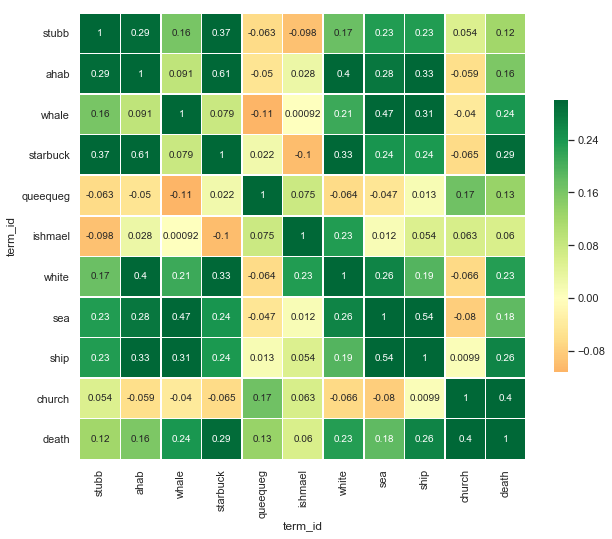

In [80]:
corr_plot_terms(terms, moby_dtm_chaps, 'By Chap')

By Chap


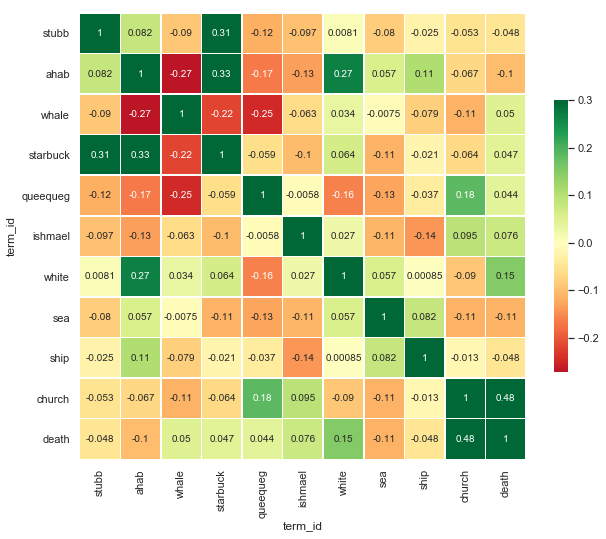

In [230]:
corr_plot_terms(terms, moby_dtm_tfidf_chaps, 'By Chap')

# PMI

In [164]:
# n_tokens = moby_bow.n.sum().sum()
# n_tokens

# moby_dtm_chaps.sum().div(n_tokens).sort_values(ascending=False).head()

# moby_vocab.loc[~moby_vocab.sw, 'p'] = moby_dtm_chaps.sum().div(n_tokens)

# moby_vocab[~moby_vocab.sw].head()

# sns.scatterplot(data=moby_vocab, x='adj_freq', y='p')
# plt.show()